# CNN Experiments for classifying step 3g

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_hub as hub
#import tensorflow_text as text

In [ ]:
! pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import transformers
print(transformers.__version__)

4.27.1


In [ ]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#0. Utilities

## Code to prepare dataset

In [ ]:
# get target and sentences for a dataframe
def get_target_sentence(df):
  """input: dataframe that contains sentences and labels.
  output: labels as pandas.core.series.Series & sentences as list"""
  labels = df.pop("new_label").to_numpy()
  sentences = df["sentence"].to_list() # list
  return sentences, labels

In [ ]:
# prepare function to check for overfitting
# check for overfitting
def plot_result(history):
  plt.plot(history.history['accuracy'], label ="Training accuracy")
  plt.plot(history.history['val_accuracy'], label ="Validation accuracy")
  plt.title("Accuracy of baseline model on step 3g")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend()
  plt.show()
  return plt

## Code to evaluate model

In [ ]:
# classification report
from sklearn.metrics import classification_report

def evaluation_report(model, X_test, y_true):
  """Returns precision, recall, fq. 
  model = the model we want to evaluate; test_data = depends on the 
  classification task (e.g. test_data_3g)."""

  # Make predictions on the test data
  y_pred = model.predict(X_test)
  y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class labels

  report = classification_report(y_true, y_pred_classes)
  return report

# 1. Load & Prepare Dataset (3g/not 3g)



## Load data

I saved a sub-dataset for each step that contains the sentences tagged with the step (class 1) and a random subset of other sentences (class 0) of the same size. Beforehand, I undersampled the set of untagged sentences to the size of sentences of step 3 such that they won't be too overrepresented when chosing a subset of other sentences.


In [ ]:
# load data (always use the same dataset)
path = 'drive/My Drive/P8/data/sub_datasets'
train_I1_3g = pd.read_csv(os.path.join(path, "train_I1_3g.csv"), encoding='utf8', dtype={'text_id': str, 'sentence': str, 'label': str}, index_col=False)
val_I1_3g = pd.read_csv(os.path.join(path, "val_I1_3g.csv"), encoding='utf8', dtype={'text_id': str, 'sentence': str, 'label': str}, index_col=False)
test_I1_3g = pd.read_csv(os.path.join(path, "test_I1_3g.csv"), encoding='utf8', dtype={'text_id': str, 'sentence': str, 'label': str}, index_col=False)

In [ ]:
train_I1_3g.head(3)

,sentence,new_label
0,anschliessend folgen zweiter theoretisch Teil ...,1
1,danach Forschungsdesign erläutern,1
2,Art Entstehung Codesystem Methodenteil ausführen,1


In [ ]:
train_I1_3g.shape

(584, 2)

## Prepare data for embedding

sentences: List of strings --> have to be embedded
labels: numpy array -> already good to use in model

In [ ]:
# get target and sentences for each sub-frame
sentences_train, labels_train = get_target_sentence(train_I1_3g)  # list of strings; numpy array with 0 and 1
sentences_val, labels_val = get_target_sentence(val_I1_3g)
sentences_test, labels_test = get_target_sentence(test_I1_3g)

# Experiments

## 1.2.2 CNN with deepset/gbert-large Embedding

### Encoding

In [ ]:
# Load the necessary libraries
from transformers import AutoTokenizer, TFAutoModel

# Load the pre-trained model and tokenizer
model_name2 = "deepset/gbert-large"
tokenizer2 = AutoTokenizer.from_pretrained(model_name2)
model2 = TFAutoModel.from_pretrained(model_name2)

Some layers from the model checkpoint at deepset/gbert-large were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at deepset/gbert-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
max_length = 50
def tokenize_and_pad2(sentences):
    # Tokenize the sentences using the tokenizer
    tokenized = tokenizer2(sentences, padding=True, truncation=True, max_length=max_length, return_tensors="tf")
    # Get the model embeddings for the tokenized sentences
    embeddings = model2(tokenized.input_ids, attention_mask=tokenized.attention_mask)[0]
    # Return the embeddings
    return embeddings.numpy()

In [ ]:
# Tokenize and pad your training sentences
sentences_train_embeddings2 = tokenize_and_pad2(sentences_train)
sentences_train_padded2 = tf.keras.preprocessing.sequence.pad_sequences(sentences_train_embeddings2, maxlen=max_length, padding='post', dtype='float32')
# Tokenize and pad your validation sentences
sentences_val_embeddings2 = tokenize_and_pad2(sentences_val)
sentences_val_padded2 = tf.keras.preprocessing.sequence.pad_sequences(sentences_val_embeddings2, maxlen=max_length, padding='post', dtype='float32')
# Tokenize and pad your test sentences
sentences_test_embeddings2 = tokenize_and_pad2(sentences_test)
sentences_test_padded2 = tf.keras.preprocessing.sequence.pad_sequences(sentences_test_embeddings2, maxlen=max_length, padding='post', dtype='float32')

In [ ]:
print(sentences_train_padded2.shape) # No of sentences, ?, ?
print(sentences_val_padded2.shape)
print(sentences_test_padded2.shape)

(584, 50, 1024)
(186, 50, 1024)
(184, 50, 1024)


### Build model

In [ ]:
cnn2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(sentences_train_padded2.shape[1], sentences_train_padded2.shape[2])),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Train model

In [ ]:
history_cnn2 = cnn2.fit(sentences_train_padded2, labels_train, 
                                              epochs=5, 
                                              batch_size=32, 
                                              validation_data=(sentences_val_padded2, labels_val))

Epoch 1/5
19/19 [==============================] - 5s 184ms/step - loss: 0.5656 - accuracy: 0.7551 - val_loss: 0.3260 - val_accuracy: 0.8548
Epoch 2/5
19/19 [==============================] - 3s 171ms/step - loss: 0.2583 - accuracy: 0.9110 - val_loss: 0.2398 - val_accuracy: 0.8925
Epoch 3/5
19/19 [==============================] - 2s 108ms/step - loss: 0.1518 - accuracy: 0.9606 - val_loss: 0.2268 - val_accuracy: 0.9032
Epoch 4/5
19/19 [==============================] - 2s 106ms/step - loss: 0.1003 - accuracy: 0.9692 - val_loss: 0.2224 - val_accuracy: 0.8978
Epoch 5/5
19/19 [==============================] - 2s 107ms/step - loss: 0.0514 - accuracy: 0.9932 - val_loss: 0.2400 - val_accuracy: 0.8925


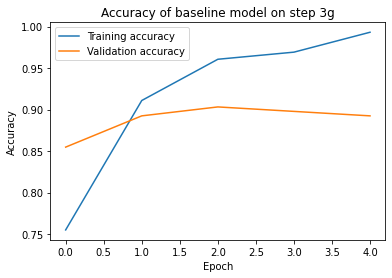

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

In [ ]:
# check for overfitting
plot_result(history_cnn2)

### Evaluate trained model

In [ ]:
# evaluate on test data:
loss, accuracy = cnn2.evaluate(sentences_test_padded2, labels_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print("\n\n")

# precision, accuracy, f1
print(evaluation_report(cnn2, sentences_test_padded2, labels_test))
print("\n\n")


6/6 [==============================] - 0s 35ms/step - loss: 0.2518 - accuracy: 0.9022
Test loss: 0.25181305408477783
Test accuracy: 0.9021739363670349



6/6 [==============================] - 0s 34ms/step
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        92
           1       0.89      0.92      0.90        92

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184






6/6 [==============================] - 0s 34ms/step


/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 8 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


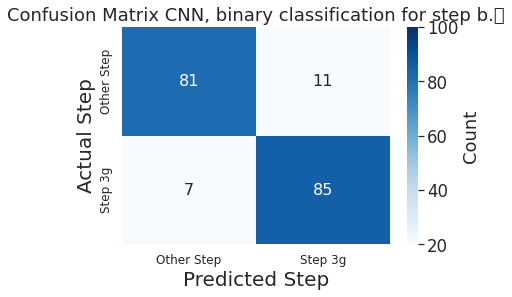

In [ ]:
# confusion matrix
y_pred2 = cnn2.predict(sentences_test_padded2)
y_pred_classes2 = (y_pred2 > 0.5).astype(int)  # Convert probabilities to binary class labels

cm2 = confusion_matrix(labels_test, y_pred_classes2)

new_label_dict = {
    1: "Step 3b", 
    0: "Other step"
}

sn.set(font_scale=1.5)
labels = ['Other Step', 'Step 3g']
fontdict = {'fontsize': 20}
ax = sn.heatmap(cm2, cmap=plt.cm.Blues, vmin=20, vmax=100, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'}, annot_kws={"size": 16}) 
ax.set_xlabel('Predicted Step', fontdict=fontdict)
ax.set_ylabel('Actual Step', fontdict=fontdict)
ax.set_title('Confusion Matrix CNN, binary classification for step b.\b')
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

## 1.2.3. CNN with Sentence Embeddings

### Encoding

In [ ]:
# Load the sentence transformer model
from transformers import AutoTokenizer,  TFAutoModel
tokenizer3 = AutoTokenizer.from_pretrained('sentence-transformers/stsb-xlm-r-multilingual')
model3 = TFAutoModel.from_pretrained('sentence-transformers/stsb-xlm-r-multilingual')

All model checkpoint layers were used when initializing TFXLMRobertaModel.

All the layers of TFXLMRobertaModel were initialized from the model checkpoint at sentence-transformers/stsb-xlm-r-multilingual.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [ ]:
def encode_sentences3(sentences):
    """Take a list of sentences and return pretrained sentence embeddings"""
    encoded_sentences = tokenizer3(sentences, padding=True, truncation=True, return_tensors='tf')['input_ids']
    embedded_sentences = model3(encoded_sentences)[0]
    return embedded_sentences

In [ ]:
# encode input data
sentences_train_embedded3 = encode_sentences3(sentences_train)
sentences_val_embedded3 = encode_sentences3(sentences_val)
sentences_test_embedded3 = encode_sentences3(sentences_test)
print(sentences_train_embedded3.shape)
print(sentences_val_embedded3.shape)
print(sentences_test_embedded3.shape)

(584, 90, 768)
(186, 62, 768)
(184, 56, 768)


In [ ]:
def pad_embedding3(input_tensor, max_seq_len):
  # calculate the amount of padding needed
  padding_length = max_seq_len - input_tensor.shape[1]
  # pad the tensor with zeros
  padded_tensor = tf.pad(input_tensor, ((0, 0), (0, padding_length), (0, 0)))

  return padded_tensor

In [ ]:
# pad the sequences with zeros to ensure they all have the same length
MAX_SEQ_LENGTH = 90
sentences_train_padded3 = pad_embedding3(sentences_train_embedded3, max_seq_len=MAX_SEQ_LENGTH)
sentences_val_padded3 = pad_embedding3(sentences_val_embedded3, max_seq_len=MAX_SEQ_LENGTH)
sentences_test_padded3 = pad_embedding3(sentences_test_embedded3, max_seq_len=MAX_SEQ_LENGTH)

In [ ]:
print(sentences_train_padded3.shape)
print(sentences_val_padded3.shape)
print(sentences_test_padded3.shape)

(584, 90, 768)
(186, 90, 768)
(184, 90, 768)


### Build model

In [ ]:
cnn3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(sentences_train_padded3.shape[1], sentences_train_padded3.shape[2])),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Train model

In [ ]:
history_cnn3 = cnn3.fit(sentences_train_padded3, labels_train, 
                                              epochs=6, 
                                              batch_size=32, 
                                              validation_data=(sentences_val_padded3, labels_val))

Epoch 1/6
19/19 [==============================] - 6s 247ms/step - loss: 0.7843 - accuracy: 0.4966 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 2/6
19/19 [==============================] - 7s 372ms/step - loss: 0.6868 - accuracy: 0.5000 - val_loss: 0.6897 - val_accuracy: 0.5000
Epoch 3/6
19/19 [==============================] - 4s 164ms/step - loss: 0.6540 - accuracy: 0.5976 - val_loss: 0.6608 - val_accuracy: 0.6667
Epoch 4/6
19/19 [==============================] - 3s 135ms/step - loss: 0.6098 - accuracy: 0.6969 - val_loss: 0.6393 - val_accuracy: 0.7366
Epoch 5/6
19/19 [==============================] - 3s 177ms/step - loss: 0.5833 - accuracy: 0.7483 - val_loss: 0.6306 - val_accuracy: 0.7581
Epoch 6/6
19/19 [==============================] - 6s 310ms/step - loss: 0.5358 - accuracy: 0.7962 - val_loss: 0.6087 - val_accuracy: 0.7849


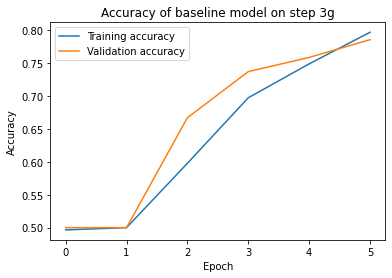

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

In [ ]:
# check for overfitting
plot_result(history_cnn3)

### Evaluate trained model

In [ ]:
# evaluate on test data:
loss, accuracy = cnn3.evaluate(sentences_test_padded3, labels_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print("\n\n")

# precision, accuracy, f1
print(evaluation_report(cnn3, sentences_test_padded3, labels_test))
print("\n\n")

6/6 [==============================] - 0s 48ms/step - loss: 0.5834 - accuracy: 0.7935
Test loss: 0.5833690762519836
Test accuracy: 0.79347825050354



6/6 [==============================] - 0s 46ms/step
              precision    recall  f1-score   support

           0       0.75      0.88      0.81        92
           1       0.86      0.71      0.77        92

    accuracy                           0.79       184
   macro avg       0.80      0.79      0.79       184
weighted avg       0.80      0.79      0.79       184






6/6 [==============================] - 1s 86ms/step


/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 8 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


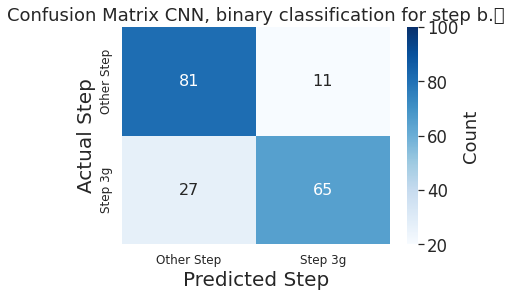

In [ ]:
# confusion matrix
y_pred3 = cnn3.predict(sentences_test_padded)
y_pred_classes3 = (y_pred3 > 0.5).astype(int)  # Convert probabilities to binary class labels

cm3 = confusion_matrix(labels_test, y_pred_classes3)

new_label_dict = {
    1: "Step 3b", 
    0: "Other step"
}

sn.set(font_scale=1.5)
labels = ['Other Step', 'Step 3g']
fontdict = {'fontsize': 20}
ax = sn.heatmap(cm, cmap=plt.cm.Blues, vmin=20, vmax=100, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'}, annot_kws={"size": 16}) 
ax.set_xlabel('Predicted Step', fontdict=fontdict)
ax.set_ylabel('Actual Step', fontdict=fontdict)
ax.set_title('Confusion Matrix CNN, binary classification for step b.\b')
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()